/Users/aaronyerke/anaconda3/envs/mlenv2019/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


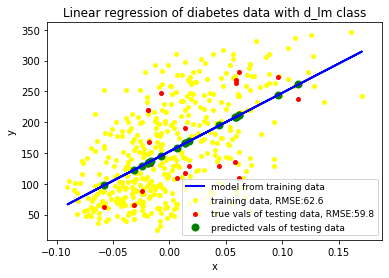

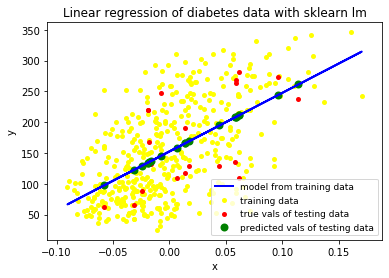

In [19]:
# Aaron Yerke, HW 1 for ML 2019
# 1. (50 points) Revise the linear regression code we went through in class by replacing the current function with a class.
# 2. (50 points) Perform linear regression on the diabetes dataset using both the linear regression class you obtain in problem 1 and sklearn.
# This dataset can be accessed via the following python code:
# from sklearn import datasets diabetes = datasets.load diabetes()
# and the linear model module in sklearn can be accessed via the following python code:
# from sklearn import linear model
# This diabetes dataset contains 10 features/variables. Select diabetes.data[:,2] as x for linear regression. The dependent variable y is diabetes.target. Split x and y into training and testing sets by randomly selecting 20 points for testing and the remaining for training. Plot the testing x vs testing y, and the testing x vs predicted y in the same plot.


# --------------------------------------------------------------------------
# Import external libraries
# --------------------------------------------------------------------------
import numpy as np
import scipy.stats as stats
from sklearn import linear_model
from sklearn import datasets
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# set up plotting parameters
# --------------------------------------------------------------------------
line_width_1 = 2
line_width_2 = 2
marker_1 = '.' # point
marker_2 = 'o' # circle
marker_size = 12
line_style_1 = ':' # dotted line
line_style_2 = '-' # solid line

# --------------------------------------------------------------------------
# set up lm class
# --------------------------------------------------------------------------
class d_lm:
    def __init__(self, x, y, confidence = 0.95):
        self.confidence = confidence
        self.x = x
        self.y = y
        self.n = len(x)
        self.x_bar = np.mean(x)
        self.y_bar = np.mean(y)
        self.S_yx = np.sum((y - self.y_bar) * (x - self.x_bar))
        self.S_xx = np.sum((x - self.x_bar)**2)
        # ====== estimate beta_0 and beta_1 ======
        self.beta_1_hat = self.S_yx / self.S_xx # also equal to (np.cov(x, y))[0, 1] / np.var(x)
        self.beta_0_hat = self.y_bar - self.beta_1_hat * self.x_bar
        # ====== estimate sigma ======
        # residual
        self.y_hat = self.beta_0_hat + self.beta_1_hat * x
        self.r = y - self.y_hat
        self.sigma_hat = np.sqrt(sum(self.r**2) / (self.n-2))
        # ====== estimate sum of squares ======
        # total sum of squares
        self.SS_total = np.sum((y - self.y_bar)**2)
        # regression sum of squares
        self.SS_reg = np.sum((self.y_hat - self.y_bar)**2)
        # residual sum of squares
        self.SS_err = np.sum((y - self.y_hat)**2)
        # ====== estimate R2: coefficient of determination ======
        self.R2 = self.SS_reg / self.SS_total
        # ====== R2 = correlation_coefficient**2 ======
        self.correlation_coefficient = np.corrcoef(x, y)
        self.delta = self.correlation_coefficient[0, 1]**2 - self.R2
        # ====== estimate MS ======
        # sample variance
        self.MS_total = self.SS_total / (self.n-1)
        self.MS_reg = self.SS_reg / 1.0
        self.MS_err = self.SS_err / (self.n-2)
        # ====== estimate F statistic ======
        self.F = self.MS_reg / self.MS_err
        self.F_test_p_value = 1 - stats.f._cdf(self.F, dfn=1, dfd=self.n-2)
        # ====== beta_1_hat statistic ======
        self.beta_1_hat_var = self.sigma_hat**2 / ((self.n-1) * np.var(x))
        self.beta_1_hat_sd = np.sqrt(self.beta_1_hat_var)
        # confidence interval
        self.z = stats.t.ppf(q=0.025, df=self.n-2)
        self.beta_1_hat_CI_lower_bound = self.beta_1_hat - self.z * self.beta_1_hat_sd
        self.beta_1_hat_CI_upper_bound = self.beta_1_hat + self.z * self.beta_1_hat_sd
        # hypothesis tests for beta_1_hat
        # H0: beta_1 = 0
        # H1: beta_1 != 0
        self.beta_1_hat_t_statistic = self.beta_1_hat / self.beta_1_hat_sd
        self.beta_1_hat_t_test_p_value = 2 * (1 - stats.t.cdf(np.abs(self.beta_1_hat_t_statistic), df=self.n-2))
        # ====== beta_0_hat statistic ======
        self.beta_0_hat_var = self.beta_1_hat_var * np.sum(x**2) / self.n
        self.beta_0_hat_sd = np.sqrt(self.beta_0_hat_var)
        # confidence interval
        self.beta_0_hat_CI_lower_bound = self.beta_0_hat - self.z * self.beta_0_hat_sd
        self.beta_1_hat_CI_upper_bound = self.beta_0_hat + self.z * self.beta_0_hat_sd
        self.beta_0_hat_t_statistic = self.beta_0_hat / self.beta_0_hat_sd
        self.beta_0_hat_t_test_p_value = 2 * (1 - stats.t.cdf(np.abs(self.beta_0_hat_t_statistic), df=self.n-2))
        # confidence interval for the regression line
        self.sigma_i = 1.0/self.n * (1 + ((x - self.x_bar) / np.std(x))**2)
        self.y_hat_sd = self.sigma_hat * self.sigma_i
        self.y_hat_CI_lower_bound = self.y_hat - self.z * self.y_hat_sd
        self.y_hat_CI_upper_bound = self.y_hat + self.z * self.y_hat_sd

    def test_model_RMSE(self, test_x, test_y):
        pred_y_test = self.beta_0_hat + self.beta_1_hat * test_x
        pred_y_train = self.beta_0_hat + self.beta_1_hat * self.x
        train_rmse = sum(((self.y - pred_y_train)**2)/len(self.y))**(1/2)
        test_rmse = sum(((test_y - pred_y_test)**2)/len(test_y))**(1/2)
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(self.x, self.y, label=f'training data, RMSE:{round(train_rmse,1)}', color='yellow', marker=marker_1, linewidth=line_width_1)
        ax.scatter(test_x, test_y, label=f'true vals of testing data, RMSE:{round(test_rmse,1)}', color='red', marker=marker_1, linewidth=line_width_1)
        ax.scatter(test_x, pred_y_test, color='green', label='predicted vals of testing data', linewidth=line_width_1)
        ax.plot(self.x, self.y_hat, color='blue', label='model from training data', linewidth=line_width_1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title("Linear regression of diabetes data with d_lm class")
        ax.legend(loc='lower right', fontsize=9)
        fig.show()
        
# --------------------------------------------------------------------------
# create training and testingdatasets
# --------------------------------------------------------------------------
diabetes = datasets.load_diabetes()
x = diabetes.data[:,2]
y = diabetes.target
n_samples = len(diabetes.target)
random_samples = np.random.randint(low = 0, high = n_samples, size = 20)
testing_x = np.asarray(x[random_samples])
training_x = np.asarray([x[i] for i in range(0, n_samples) if i not in random_samples])
testing_y = np.asarray(y[random_samples])
training_y = np.asarray([y[i] for i in range(0, n_samples) if i not in random_samples])

# --------------------------------------------------------------------------
# run homemade lm model
# --------------------------------------------------------------------------
my_lm = d_lm(training_x, training_y)
my_lm.test_model_RMSE(testing_x , testing_y)

# --------------------------------------------------------------------------
# run professional lm model
# --------------------------------------------------------------------------

training_x = training_x.reshape((len(training_x), 1))
testing_x = testing_x.reshape((len(testing_x), 1))
skl_lm = linear_model.LinearRegression().fit(training_x, training_y)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(training_x, training_y, label=f'training data', color='yellow', marker=marker_1, linewidth=line_width_1)
ax.scatter(testing_x, testing_y, label=f'true vals of testing data', color='red', marker=marker_1, linewidth=line_width_1)
ax.scatter(testing_x, skl_lm.predict(testing_x), color='green', label='predicted vals of testing data', linewidth=line_width_1)
ax.plot(training_x, skl_lm.predict(training_x), color='blue', label='model from training data', linewidth=line_width_1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Linear regression of diabetes data with sklearn lm")
ax.legend(loc='lower right', fontsize=9)






In [20]:
20/442

0.04524886877828054